## Using Orange for classification

Orange implements function for construction of classification models, their evaluation and scoring. 

In [1]:
import Orange
import numpy as np
from numpy import random

### Learners and Classifiers

Classification uses two types of objects: learners and classifiers. Learners consider class-labeled data and return a classifier. Given the first three data instances, classifiers return the indexes of predicted class:

In [2]:
data = Orange.data.Table("voting")
learner = Orange.classification.LogisticRegressionLearner()
classifier = learner(data)
classifier(data[:3])

array([ 0.,  0.,  1.])

Above, we read the data, constructed a logistic regression learner, gave it the dataset to construct a classifier, and used it to predict the class of the first three data instances. We also use these concepts in the following code that predicts the classes of the selected three instances in the dataset:

In [3]:
learner = Orange.classification.LogisticRegressionLearner()
classifier = learner(data)
c_values = data.domain.class_var.values
for d in data[5:8]:
    c = classifier(d)
    print("{}, originally {}".format(c_values[int(classifier(d)[0])],
                                     d.get_class()))

democrat, originally democrat
republican, originally democrat
republican, originally republican


Logistic regression has made a mistake in the second case, but otherwise predicted correctly. No wonder, since this was also the data it trained from. The following code counts the number of such mistakes in the entire dataset:

In [4]:
data = Orange.data.Table("voting")
learner = Orange.classification.LogisticRegressionLearner()
classifier = learner(data)
print(np.sum(data.Y != classifier(data)))

11


This number does not tell us much about the accuracy of the classifier. Last week we learnt of a better way.

In [5]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(data.Y, classifier(data)))

Accuracy: 0.974712643678


To find out what is the probability that the classifier assigns to, say, democrat class, we need to call the classifier with additional parameter that specifies the classification output type.

In [6]:
data = Orange.data.Table("voting")
learner = Orange.classification.LogisticRegressionLearner()
classifier = learner(data)
target_class = 1
print("Probabilities for %s:" % data.domain.class_var.values[target_class])
probabilities = classifier(data, 1)
for p, d in zip(probabilities[5:8], data[5:8]):
    print(p[target_class], d.get_class())

Probabilities for democrat:
0.995182817108 democrat
0.1670249087 democrat
0.0812221255942 republican


Orange includes a variety of classification algorithms, most of them wrapped from `scikit-learn`, including:

* logistic regression (`Orange.classification.LogisticRegressionLearner`)
* k-nearest neighbors (`Orange.classification.knn.KNNLearner`)
* support vector machines (say, `Orange.classification.svm.LinearSVMLearner`)
* classification trees (`Orange.classification.tree.SklTreeLearner`)
* random forest (`Orange.classification.RandomForestLearner`)

Some of these are included in the code that estimates the probability of a target class on a testing data. This time, training and test datasets are disjoint:

In [7]:
import random
random.seed(42)
data = Orange.data.Table("voting")
test = Orange.data.Table(data.domain, random.sample(data, 5))
train = Orange.data.Table(data.domain, [d for d in data if d not in test])

tree = Orange.classification.tree.TreeLearner(max_depth=3)
knn = Orange.classification.knn.KNNLearner(n_neighbors=3)
lr = Orange.classification.LogisticRegressionLearner(C=0.1)

learners = [tree, knn, lr]
classifiers = [learner(train) for learner in learners]

target = 0
print("Probabilities for %s:" % data.domain.class_var.values[target])
print("original class ", " ".join("%-5s" % l.name for l in classifiers))

c_values = data.domain.class_var.values
for d in test:
    print(("{:<15}" + " {:.3f}"*len(classifiers)).format(
        c_values[int(d.get_class())],
        *(c(d, 1)[0][target] for c in classifiers)))

Probabilities for republican:
original class  tree  knn   logistic regression
republican      0.975 1.000 0.917
republican      0.975 1.000 0.947
democrat        0.008 0.000 0.028
republican      0.975 1.000 0.937
republican      0.975 0.667 0.793


##### Question 5-3-1
Test different classifiers. Which works best on given data?

### ROC curve and Area Under Curve (AUC)

The ROC curve is a way to assess the quality of the classification. Typically, the y axis indicates true positive rate, and the x axis the false positive rate. The upper left corner represents an ideal model without false positives and with a 100% true positive rate.

In [8]:
random.seed(42)  # zagotovi ponovljivost naključnih rezultatov

data = Orange.data.Table('titanic')
inxs = list(range(len(data)))
n = len(inxs)

random.shuffle(inxs)

data_training = data[inxs[:n//2]]
data_test     = data[inxs[n//2:]]

learner = Orange.classification.LogisticRegressionLearner()
classifier = learner(data_training)
classifier(data_test)

array([ 0.,  0.,  0., ...,  1.,  0.,  0.])

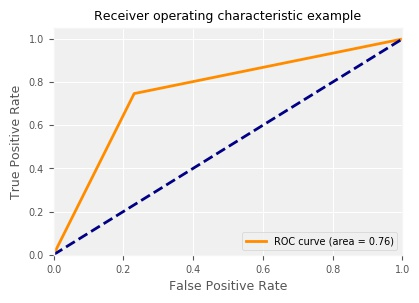

In [9]:
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")

import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(classifier(data_test), data_test.Y)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##### Question 5-3-2
Find models with a larger area under curve.

### Cross-Validation

Validating the accuracy of classifiers on the training data, as we did above, serves demonstration purposes only. Any performance measure that assesses accuracy should be estimated on the independent test set. Such is also a procedure called cross-validation, which averages the evaluation scores across several runs, each time considering a different training and test subsets as sampled from the original dataset:

In [10]:
data = Orange.data.Table("titanic")
lr = Orange.classification.LogisticRegressionLearner()
res = Orange.evaluation.CrossValidation(data, [lr], k=5)
print("Accuracy: %.3f" % Orange.evaluation.scoring.CA(res)[0])
print("AUC:      %.3f" % Orange.evaluation.scoring.AUC(res)[0])

Accuracy: 0.778
AUC:      0.756


Cross-validation is expecting a list of learners. The performance estimators also return a list of scores, one for every learner. There was just one learner (lr) in the script above, hence the array of length one was returned. The script estimates classification accuracy and area under ROC curve.

The following code cross-validates three learners on the titanic dataset.

In [11]:
data = Orange.data.Table("titanic")
tree = Orange.classification.tree.TreeLearner(max_depth=3)
knn = Orange.classification.knn.KNNLearner(n_neighbors=3)
lr = Orange.classification.LogisticRegressionLearner(C=0.1)
learners = [tree, knn, lr]

print(" "*9 + " ".join("%-4s" % learner.name for learner in learners))
res = Orange.evaluation.CrossValidation(data, learners, k=5)
print("Accuracy %s" % " ".join("%.2f" % s for s in Orange.evaluation.CA(res)))
print("AUC      %s" % " ".join("%.2f" % s for s in Orange.evaluation.AUC(res)))

         tree knn  logistic regression
Accuracy 0.79 0.48 0.78
AUC      0.77 0.66 0.74


Of course, we can also cross-check learners of the same type with different parameters.

In [12]:
data = Orange.data.Table("titanic")
knn3 = Orange.classification.knn.KNNLearner(n_neighbors=3)
knn5 = Orange.classification.knn.KNNLearner(n_neighbors=5)
knn7 = Orange.classification.knn.KNNLearner(n_neighbors=7)
learners = [knn3, knn5, knn7]

print(" "*10 + " ".join("%-4s" % learner.name for learner in learners))
res = Orange.evaluation.CrossValidation(data, learners, k=5)
print("neighbors " + " ".join(" %i  " % i for i in [3, 6, 9]))
print("Accuracy  %s" % " ".join("%.2f" % s for s in Orange.evaluation.CA(res)))
print("AUC       %s" % " ".join("%.2f" % s for s in Orange.evaluation.AUC(res)))

          knn  knn  knn 
neighbors  3    6    9  
Accuracy  0.48 0.50 0.39
AUC       0.66 0.65 0.65


##### Question 5-3-3
Select a classifying method and use cross validation to evaluate different parameter values.